MACD Strategy

Trading strategies:
1. MACD crossover (cross between the MACD and signal lines)
2. Zero cross (The MACD line crosses above zero)
3. MACD crossover with a 100 EMA market direction filter

In [1]:
#import libraries
import yfinance as yf
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
#define variables
SYMBOL = "SPY"
STARTING_BALANCE = 10000
systems = ["Sys_cross", "Sys_zero_cross", "Sys_cross_100ema"]

In [3]:
#define time period
intervals = ['1h', '1d']
interval = intervals[1]

if interval == '1d':
    #yearly data
    START = datetime.datetime(2005, 1, 1)
    END = datetime.datetime(2025, 1, 11)
elif interval == '1h':
    # hourly data
    START = datetime.datetime(2023, 1, 13)
    END = datetime.datetime(2025, 1, 11)

DAYS = END - START
YEARS = DAYS.days / 365.25

In [4]:
price = yf.download(SYMBOL, start=START, end=END, interval=interval, progress=False, multi_level_index=False)

price.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,82.564323,83.566350,82.289794,83.429083,55748000
2005-01-04,81.555412,82.729019,81.287748,82.674112,69167600
2005-01-05,80.992607,81.843642,80.985742,81.493618,65667300
2005-01-06,81.404457,81.775071,81.164246,81.287784,47814700
2005-01-07,81.287750,81.829944,81.074987,81.651499,55847700


In [5]:
#drop last two columns as they are not needed
price = price.drop(['High', 'Low', 'Volume'], axis=1)

price.head()

,Close,Open
Date,,
2005-01-03,82.564323,83.429083
2005-01-04,81.555412,82.674112
2005-01-05,80.992607,81.493618
2005-01-06,81.404457,81.287784
2005-01-07,81.287750,81.651499


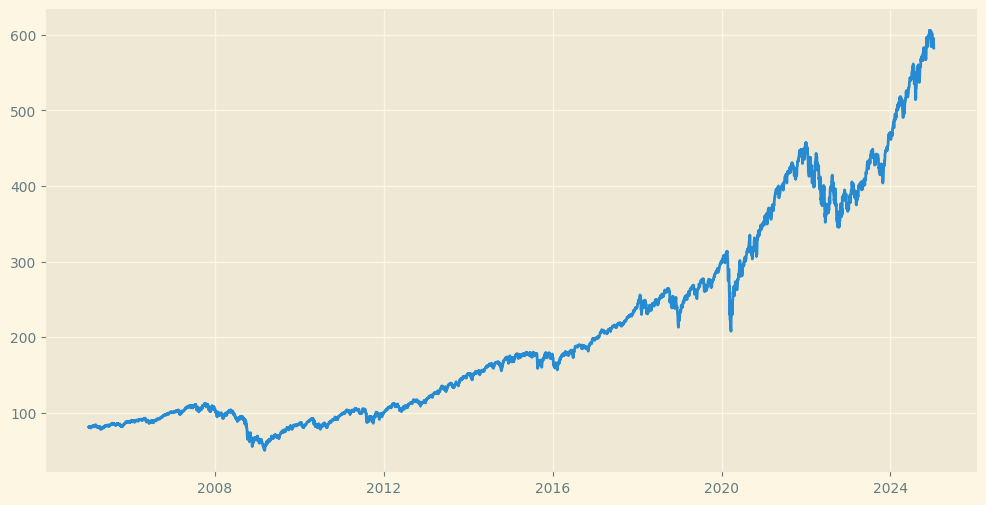

In [6]:
#plot chart
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12, 6))
plt.plot(price.Close)
plt.show()

In [7]:
#calculate daily return for close/close and close/open
price['Return'] = price.Close / price.Close.shift(1)

#calculate buy and hold balance
price['Bench_Bal'] = price.Return.cumprod() * STARTING_BALANCE

price.tail()

,Close,Open,Return,Bench_Bal
Date,,,,
2025-01-03,591.950012,587.530029,1.012503,71695.617144
2025-01-06,595.359985,596.270020,1.005761,72108.625209
2025-01-07,588.630005,597.419983,0.988696,71293.505532
2025-01-08,589.489990,588.700012,1.001461,71397.664969
2025-01-10,580.489990,585.880005,0.984733,70307.605774


In [8]:
#calculate MACD
exp1 = price.Close.ewm(span = 12, adjust=False).mean()
exp2 = price.Close.ewm(span = 26, adjust=False).mean()

price['macd'] = exp1 - exp2
price['signal'] = price['macd'].ewm(span = 9, adjust=False).mean()
price['histogram'] = price['macd'] - price['signal']

In [9]:
# Calculate 100 EMA
price['100_EMA'] = price['Close'].ewm(span=100, adjust=False).mean()

#add columns for entries
price['Sys_cross_signal'] = price['macd'] > price['signal']
price['Sys_zero_cross_signal'] = price['macd'] > 0
price['Sys_cross_100ema_signal'] = np.where((price['macd'] > price['signal']) & (price['Close'] > price['100_EMA']), True, False)

price.tail()

,Close,Open,Return,Bench_Bal,macd,signal,histogram,100_EMA,Sys_cross_signal,Sys_zero_cross_signal,Sys_cross_100ema_signal
Date,,,,,,,,,,,
2025-01-03,591.950012,587.530029,1.012503,71695.617144,-1.135164,0.443782,-1.578946,577.156901,False,False,False
2025-01-06,595.359985,596.270020,1.005761,72108.625209,-0.830628,0.188900,-1.019528,577.517359,False,False,False
2025-01-07,588.630005,597.419983,0.988696,71293.505532,-1.119431,-0.072766,-1.046664,577.737411,False,False,False
2025-01-08,589.489990,588.700012,1.001461,71397.664969,-1.264340,-0.311081,-0.953259,577.970135,False,False,False
2025-01-10,580.489990,585.880005,0.984733,70307.605774,-2.081414,-0.665148,-1.416266,578.020033,False,False,False


In [10]:
#calculate the daily return from Open to Open on days in the market
#on days when there is no trade, return is 1
for sys in systems:
    price[f'{sys}_Return'] = np.where(price[f'{sys}_signal'].shift(1) == True, price.Return, 1)
    
    #calculate system balance
    price[f'{sys}_Bal'] = STARTING_BALANCE * price[f'{sys}_Return'].cumprod()
    
price.tail()

,Close,Open,Return,Bench_Bal,macd,signal,histogram,100_EMA,Sys_cross_signal,Sys_zero_cross_signal,Sys_cross_100ema_signal,Sys_cross_Return,Sys_cross_Bal,Sys_zero_cross_Return,Sys_zero_cross_Bal,Sys_cross_100ema_Return,Sys_cross_100ema_Bal
Date,,,,,,,,,,,,,,,,,
2025-01-03,591.950012,587.530029,1.012503,71695.617144,-1.135164,0.443782,-1.578946,577.156901,False,False,False,1.0,29813.336755,1.0,32018.358463,1.0,19545.214885
2025-01-06,595.359985,596.270020,1.005761,72108.625209,-0.830628,0.188900,-1.019528,577.517359,False,False,False,1.0,29813.336755,1.0,32018.358463,1.0,19545.214885
2025-01-07,588.630005,597.419983,0.988696,71293.505532,-1.119431,-0.072766,-1.046664,577.737411,False,False,False,1.0,29813.336755,1.0,32018.358463,1.0,19545.214885
2025-01-08,589.489990,588.700012,1.001461,71397.664969,-1.264340,-0.311081,-0.953259,577.970135,False,False,False,1.0,29813.336755,1.0,32018.358463,1.0,19545.214885
2025-01-10,580.489990,585.880005,0.984733,70307.605774,-2.081414,-0.665148,-1.416266,578.020033,False,False,False,1.0,29813.336755,1.0,32018.358463,1.0,19545.214885


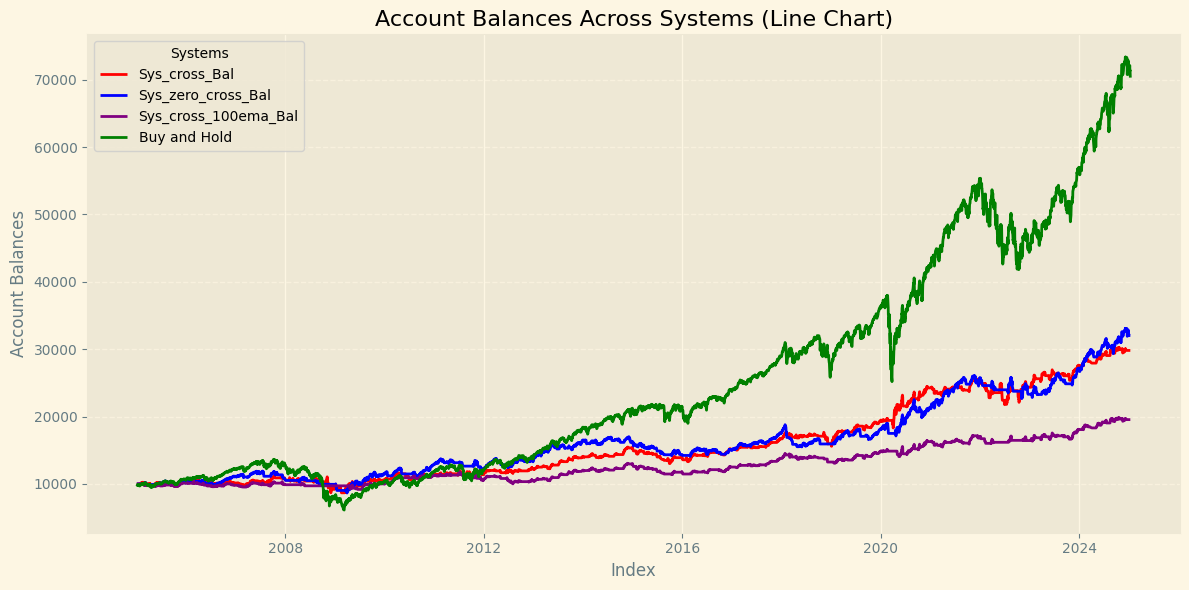

In [11]:
# Plotting
plt.figure(figsize=(12, 6))
colours = ['red', 'blue', 'purple']

# Plot each system's balance as a separate line
for idx, sys in enumerate(systems):
    plt.plot(price[f'{sys}_Bal'], label=f'{sys}_Bal', color=colours[idx])

plt.plot(price.Bench_Bal, label='Buy and Hold', color='green')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Account Balances')
plt.title('Account Balances Across Systems (Line Chart)')
plt.legend(title='Systems')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
#calculate drawdown
#benchmark
price['Bench_Peak'] = price.Bench_Bal.cummax()

price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round((((price.Bench_DD / price.Bench_Peak).min()) * 100), 2)

#system
for sys in systems:
    price[f'{sys}_Peak'] = price[f'{sys}_Bal'].cummax()

    price[f'{sys}_DD'] = price[f'{sys}_Peak'] - price[f'{sys}_Bal']

In [13]:
#calculate metrics
bench_return = round(((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[1]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[1])**(1/YEARS))-1)*100), 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark Annual return: {bench_cagr}%')
print(f'Benchmark DD: {bench_dd}%')
for sys in systems:
    print('')
    sys_return = round(((price[f'{sys}_Bal'].iloc[-1]/price[f'{sys}_Bal'].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((price[f'{sys}_Bal'].iloc[-1]/price[f'{sys}_Bal'].iloc[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price[f'{sys}_DD'] / price[f'{sys}_Peak']).max()) * -100, 2)
    sys_tim = round((price[f'{sys}_signal'].sum() / price.shape[0]) * 100, 2)
    print(f'{sys} results:')
    print(f'System Total return: {sys_return}%')
    print(f'System Annual return: {sys_cagr}%')
    print(f'System DD: {sys_dd}%')
    print(f'System Time in the Market: {sys_tim}%')


Benchmark Total return: 611.77%
Benchmark Annual return: 10.3%
Benchmark DD: -55.19%

Sys_cross results:
System Total return: 198.13%
System Annual return: 5.61%
System DD: -22.91%
System Time in the Market: 51.36%

Sys_zero_cross results:
System Total return: 220.18%
System Annual return: 5.98%
System DD: -27.27%
System Time in the Market: 69.82%

Sys_cross_100ema results:
System Total return: 95.45%
System Annual return: 3.4%
System DD: -15.26%
System Time in the Market: 42.17%
